In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'

In [4]:
import FinanceDataReader as fdr
stock = fdr.DataReader('005930')

Text(0, 0.5, 'price')

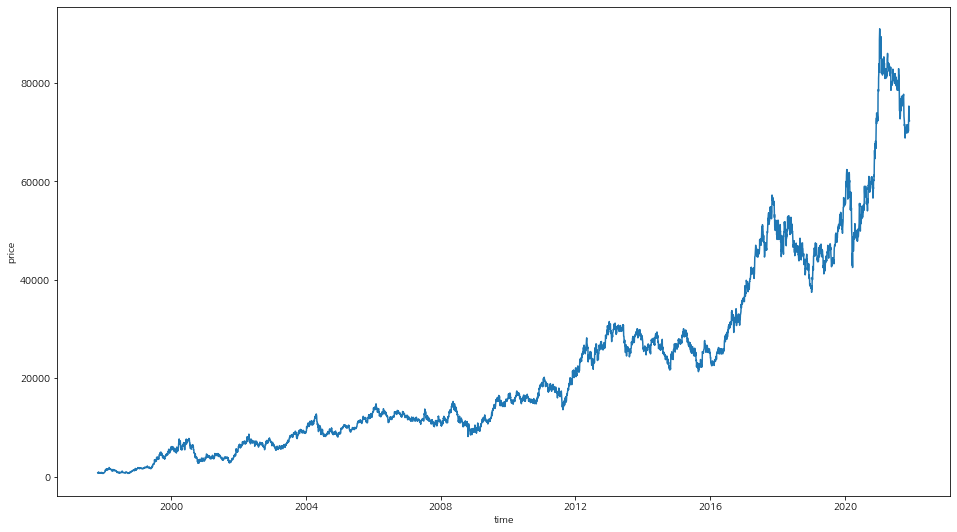

In [5]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=stock['Close'], x=stock.index)
plt.xlabel('time')
plt.ylabel('price')

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
# 스케일 후 columns
scaled = scaler.fit_transform(stock[scale_cols])
scaled

array([[8.80398671e-03, 8.76033058e-03, 8.17877095e-03, 1.62659201e-03,
        4.98769868e-03],
       [8.30564784e-03, 7.98553719e-03, 7.97765363e-03, 9.73742158e-04,
        4.13626191e-03],
       [7.90697674e-03, 7.37603306e-03, 7.34078212e-03, 5.53262589e-04,
        4.71043083e-03],
       ...,
       [8.31672204e-01, 7.75826446e-01, 8.22346369e-01, 8.08571144e-01,
        1.39074185e-01],
       [8.13953488e-01, 7.65495868e-01, 8.04469274e-01, 7.93079792e-01,
        1.43979542e-01],
       [7.94019934e-01, 7.54132231e-01, 7.97765363e-01, 7.93079792e-01,
        1.84061972e-01]])

In [7]:
df = pd.DataFrame(scaled, columns=scale_cols)

In [8]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, random_state=0, shuffle=False)

In [12]:
import tensorflow as tf

In [13]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [14]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [15]:
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [16]:
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [18]:
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [19]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [21]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
    149/Unknown - 1s 4ms/step - loss: 1.5883e-04 - mse: 3.1766e-04
Epoch 00001: val_loss improved from inf to 0.00475, saving model to tmp\ckeckpointer.ckpt
150/150 [==============================] - 1s 8ms/step - loss: 1.5850e-04 - mse: 3.1700e-04 - val_loss: 0.0047 - val_mse: 0.0095
Epoch 2/50
137/150 [==========================>...] - ETA: 0s - loss: 2.6296e-05 - mse: 5.2592e-05
Epoch 00002: val_loss improved from 0.00475 to 0.00389, saving model to tmp\ckeckpointer.ckpt
150/150 [==============================] - 1s 5ms/step - loss: 2.8753e-05 - mse: 5.7506e-05 - val_loss: 0.0039 - val_mse: 0.0078
Epoch 3/50
140/150 [===========================>..] - ETA: 0s - loss: 2.5620e-05 - mse: 5.1240e-05
Epoch 00003: val_loss improved from 0.00389 to 0.00350, saving model to tmp\ckeckpointer.ckpt
150/150 [==============================] - 1s 5ms/step - loss: 2.7042e-05 - mse: 5.4084e-05 - val_loss: 0.0035 - val_mse: 0.0070
Epoch 4/50
141/150 [===========================>..] - ETA: 

In [22]:
model.load_weights(filename)

In [23]:
pred = model.predict(test_data)

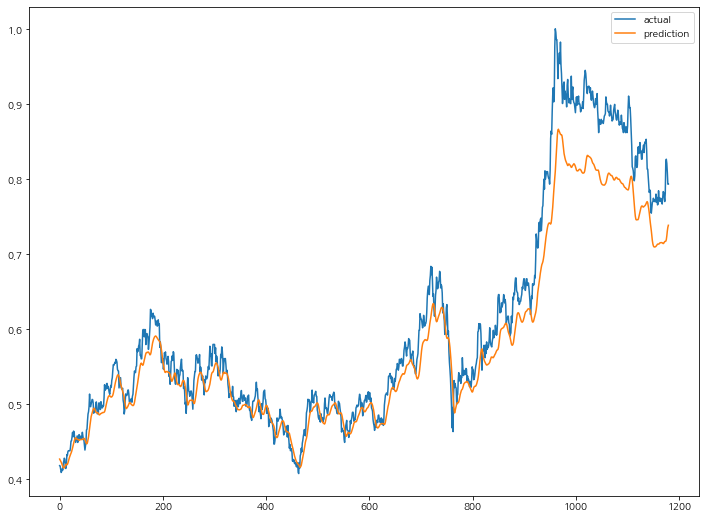

In [24]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()